# Aplicación

![Alt text](Rio_Magdalena_map.png)

## Mapa de Flujo

1. Prueba de Modelos AR y ARMA para encontrar el mejor ajuste de parámetros.
2. Obtención de residuos en el entrenamiento y en los datos de entrenamiento.
3. Entrenamiento del Modelo de Machine Learning con los residuos:
   - Utilización de un lag de 1
   - Inclusión de una variable adicional (ENSO).
4. Suma de los resultados de los Modelos de Machine Learning y ARIMA.
5. Obtención de Métricas para Evaluar los modelos.


## Librerias Necesarias

In [510]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from tensorflow import keras

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Errores
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Dataset

In [511]:
import pandas as pd

# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/aapineda/data/main/Q_Station_29037020.csv' ##CALAMAR
#url = 'https://raw.githubusercontent.com/aapineda/data/main/Q_Station_21237020.csv'
#url = 'https://raw.githubusercontent.com/aapineda/data/main/Q_Station_25027020.csv'



# Leer el archivo CSV desde la URL
df = pd.read_csv(url)

*Diccionario*

- **Date:** La fecha en la que se registraron los datos de flujo del río.
- **Flow:** El caudal o flujo del río registrado en la fecha correspondiente.
- **ENSO:** El Índice de Oscilación del El Niño-Oscilación del Sur (ENSO, por sus siglas en inglés), que representa las condiciones climáticas de El Niño o La Niña en la fecha registrada.


In [512]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13515 entries, 0 to 13514
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13515 non-null  object 
 1   Flow    13515 non-null  float64
 2   ENSO    13515 non-null  float64
dtypes: float64(2), object(1)
memory usage: 316.9+ KB


In [513]:
df['Flow'].interpolate(method='linear', inplace=True)

In [514]:
df.head()

,Date,Flow,ENSO
0,1-01-1984,7803.0,-0.6
1,2-01-1984,7718.0,-0.6
2,3-01-1984,7634.0,-0.6
3,4-01-1984,7554.0,-0.6
4,5-01-1984,7498.0,-0.6


In [515]:
df.describe()

,Flow,ENSO
count,13515.000000,13515.000000
mean,7239.553703,-0.003492
std,2708.667922,0.850624
min,2011.900000,-1.800000
25%,5177.200000,-0.600000
50%,6987.000000,-0.100000
75%,9157.050000,0.500000
max,14909.000000,2.600000


In [516]:
df.isnull().sum()

Date    0
Flow    0
ENSO    0
dtype: int64

In [517]:
(df.isnull().sum()/(len(df)))*100

Date    0.0
Flow    0.0
ENSO    0.0
dtype: float64

In [518]:

# Asegúrate de que la columna 'fecha' sea de tipo datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')


# Agrupa los datos por mes y calcula el promedio
serie = df.groupby(df['Date'].dt.to_period('M')).mean()
#serie = df

serie = serie.reset_index(drop=True)

# La variable promedio_por_mes ahora contiene el promedio de 'valor' por mes
print(serie)

                   Date          Flow  ENSO
0   1984-01-16 00:00:00   7046.387097  -0.6
1   1984-02-15 00:00:00   5769.344828  -0.4
2   1984-03-16 00:00:00   5016.483871  -0.3
3   1984-04-15 12:00:00   4613.266667  -0.4
4   1984-05-16 00:00:00   6783.838710  -0.5
..                  ...           ...   ...
439 2020-08-16 00:00:00   7277.535484  -0.6
440 2020-09-15 12:00:00   8679.066667  -0.9
441 2020-10-16 00:00:00   9349.567742  -1.2
442 2020-11-15 12:00:00   9804.350000  -1.3
443 2020-12-16 00:00:00  10353.732258  -1.2

[444 rows x 3 columns]


In [519]:
serie

,Date,Flow,ENSO
0,1984-01-16 00:00:00,7046.387097,-0.6
1,1984-02-15 00:00:00,5769.344828,-0.4
2,1984-03-16 00:00:00,5016.483871,-0.3
3,1984-04-15 12:00:00,4613.266667,-0.4
4,1984-05-16 00:00:00,6783.838710,-0.5
...,...,...,...
439,2020-08-16 00:00:00,7277.535484,-0.6
440,2020-09-15 12:00:00,8679.066667,-0.9
441,2020-10-16 00:00:00,9349.567742,-1.2
442,2020-11-15 12:00:00,9804.350000,-1.3


In [520]:
serie['Mes'] = range(1, len(serie) + 1) #PREDECIR CON MESES
#serie = serie.drop(columns='Date')

In [521]:
serie

,Date,Flow,ENSO,Mes
0,1984-01-16 00:00:00,7046.387097,-0.6,1
1,1984-02-15 00:00:00,5769.344828,-0.4,2
2,1984-03-16 00:00:00,5016.483871,-0.3,3
3,1984-04-15 12:00:00,4613.266667,-0.4,4
4,1984-05-16 00:00:00,6783.838710,-0.5,5
...,...,...,...,...
439,2020-08-16 00:00:00,7277.535484,-0.6,440
440,2020-09-15 12:00:00,8679.066667,-0.9,441
441,2020-10-16 00:00:00,9349.567742,-1.2,442
442,2020-11-15 12:00:00,9804.350000,-1.3,443


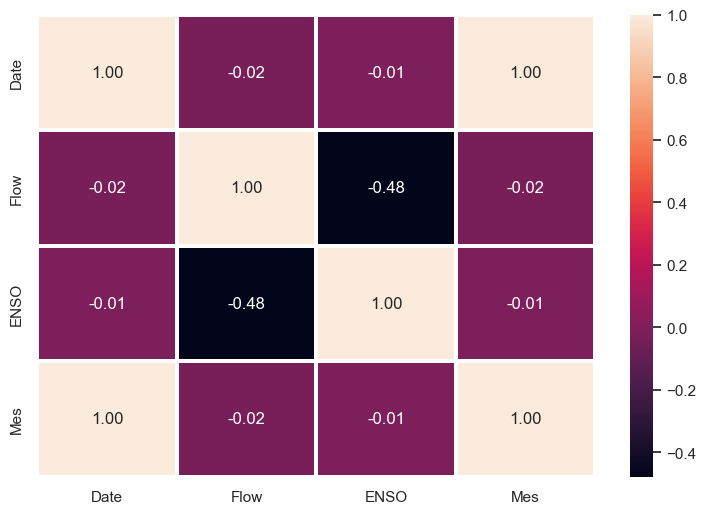

In [522]:
corr = serie.corr()

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

### Relacion entre ENSO y Caudal

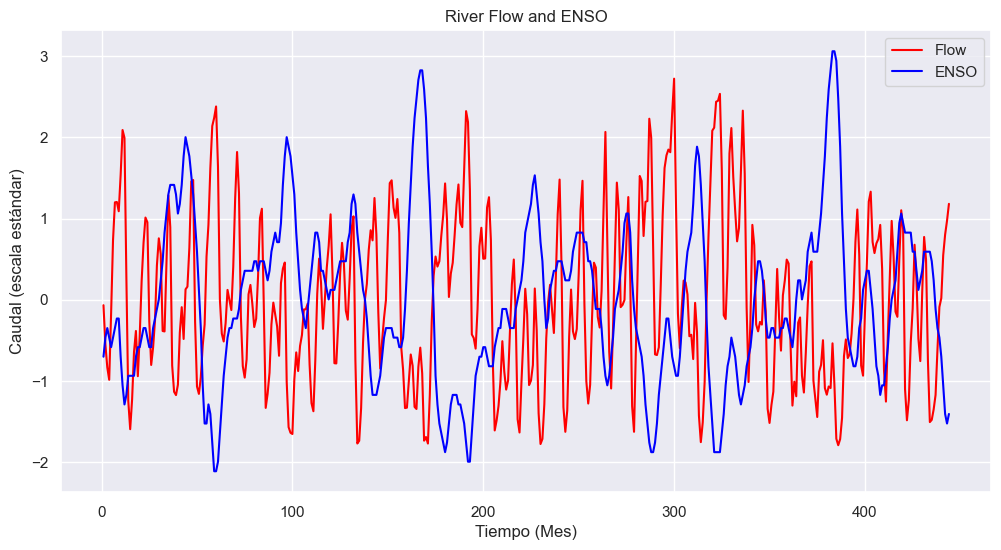

In [523]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # Importa StandardScaler desde sklearn.preprocessing si no está ya importado

# Escala las series 'Flow' y 'ENSO' usando StandardScaler
scaler = StandardScaler()
scaled_flow = scaler.fit_transform(serie[['Flow']])
scaled_enso = scaler.fit_transform(serie[['ENSO']])

# Crea una figura y traza las series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(serie['Mes'], scaled_flow, color='red', label='Flow')
ax.plot(serie['Mes'], scaled_enso, color='blue', label='ENSO')  # Usamos un color diferente (azul) para ENSO
ax.set_xlabel('Tiempo (Mes)')
ax.set_ylabel('Caudal (escala estándar)')
ax.legend()
ax.set_title('River Flow and ENSO')
ax.tick_params(axis='x', rotation=0)  # Rotate x-axis labels for readability
plt.show()


#### Lag a los datos

In [524]:
serie['Flow_lag'] = serie['Flow'].shift(1)
serie['ENSO_lag'] = serie['ENSO'].shift(1)

In [525]:
serie

,Date,Flow,ENSO,Mes,Flow_lag,ENSO_lag
0,1984-01-16 00:00:00,7046.387097,-0.6,1,NaN,NaN
1,1984-02-15 00:00:00,5769.344828,-0.4,2,7046.387097,-0.6
2,1984-03-16 00:00:00,5016.483871,-0.3,3,5769.344828,-0.4
3,1984-04-15 12:00:00,4613.266667,-0.4,4,5016.483871,-0.3
4,1984-05-16 00:00:00,6783.838710,-0.5,5,4613.266667,-0.4
...,...,...,...,...,...,...
439,2020-08-16 00:00:00,7277.535484,-0.6,440,6987.390323,-0.4
440,2020-09-15 12:00:00,8679.066667,-0.9,441,7277.535484,-0.6
441,2020-10-16 00:00:00,9349.567742,-1.2,442,8679.066667,-0.9
442,2020-11-15 12:00:00,9804.350000,-1.3,443,9349.567742,-1.2


In [526]:
serie.at[0, 'Flow_lag'] = 7490.387
#serie.at[0, 'ENSO_lag'] = -0.8
#serie.at[1, 'ENSO_lag'] = -1
serie.at[0, 'ENSO_lag'] = -0.9



In [527]:
serie

,Date,Flow,ENSO,Mes,Flow_lag,ENSO_lag
0,1984-01-16 00:00:00,7046.387097,-0.6,1,7490.387000,-0.9
1,1984-02-15 00:00:00,5769.344828,-0.4,2,7046.387097,-0.6
2,1984-03-16 00:00:00,5016.483871,-0.3,3,5769.344828,-0.4
3,1984-04-15 12:00:00,4613.266667,-0.4,4,5016.483871,-0.3
4,1984-05-16 00:00:00,6783.838710,-0.5,5,4613.266667,-0.4
...,...,...,...,...,...,...
439,2020-08-16 00:00:00,7277.535484,-0.6,440,6987.390323,-0.4
440,2020-09-15 12:00:00,8679.066667,-0.9,441,7277.535484,-0.6
441,2020-10-16 00:00:00,9349.567742,-1.2,442,8679.066667,-0.9
442,2020-11-15 12:00:00,9804.350000,-1.3,443,9349.567742,-1.2


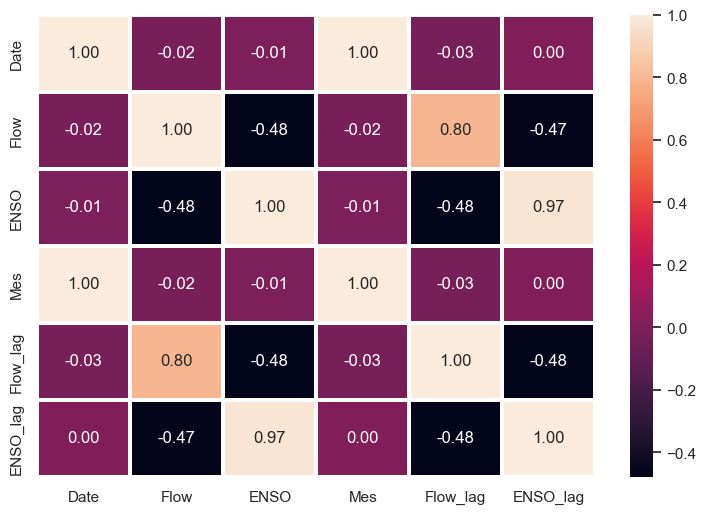

In [528]:
corr = serie.corr()

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

Column:  Flow
Skew: 0.35
Kurtosis:  -0.51


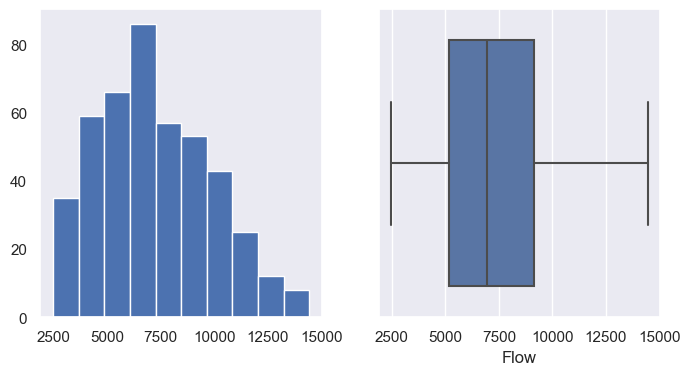

Column:  ENSO
Skew: 0.43
Kurtosis:  0.26


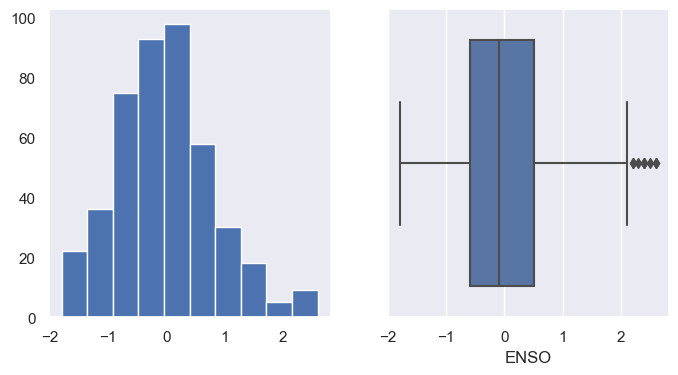

Column:  Mes
Skew: 0.0
Kurtosis:  -1.2


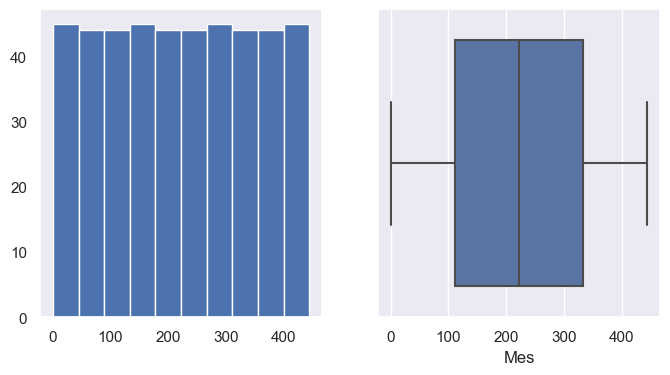

In [529]:
from scipy.stats import kurtosis
num_cols = serie.select_dtypes(include=np.number).columns.tolist()

sns.set(font_scale=1)
for col in num_cols[:3]:
    print('Column: ', col)
    print('Skew:', round( serie[col].skew(), 2))
    print('Kurtosis: ', round( serie[col].kurtosis(), 2))
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    serie[col].hist(grid=False)
    plt.subplot(1, 2, 2)
    sns.boxplot(x= serie[col])
    plt.show()

* Serie usada para modelos ARIMA

In [530]:
serie_ARIMA= serie[['Flow', 'Mes']].copy()


In [531]:
serie_ARIMA

,Flow,Mes
0,7046.387097,1
1,5769.344828,2
2,5016.483871,3
3,4613.266667,4
4,6783.838710,5
...,...,...
439,7277.535484,440
440,8679.066667,441
441,9349.567742,442
442,9804.350000,443


### Auto Correlation function (ACF) and Partial Autocorrelation Funcion(PACF).

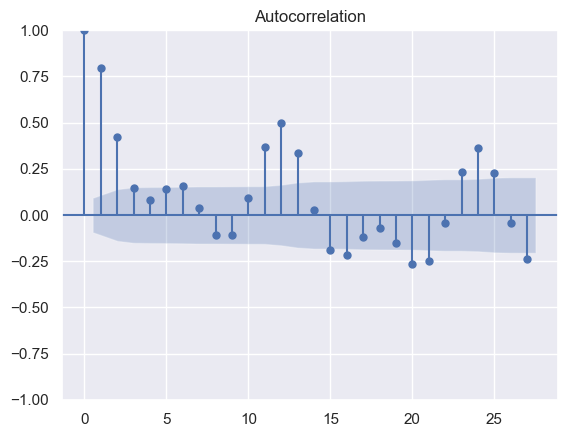

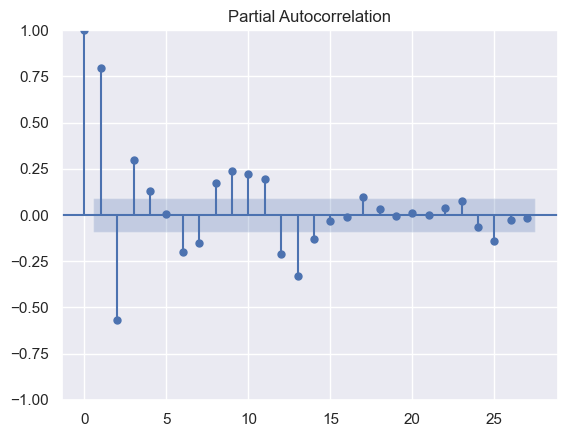

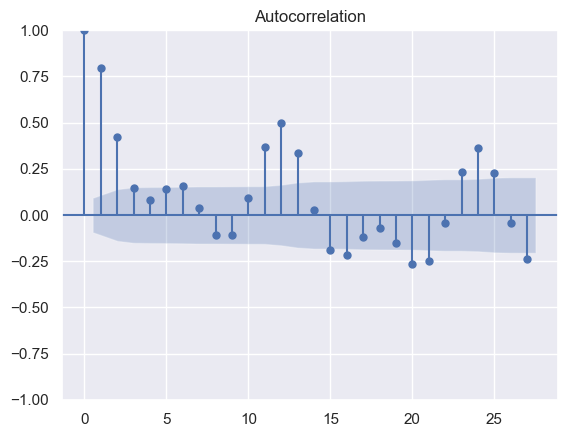

In [532]:
plot_pacf(serie_ARIMA['Flow'])
plot_acf(serie_ARIMA['Flow'])

In [533]:
#Function to know stacionality

def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios (Stationary)")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos son no estacionarios (Non Stationary)")

In [534]:
Prueba_Dickey_Fuller(serie_ARIMA['Flow'],"Flow")

Resultados de la prueba de Dickey-Fuller para columna: Flow
Test Statistic                         -5.555584
p-value                                 0.000002
No Lags Used                           13.000000
Número de observaciones utilizadas    430.000000
Critical Value (1%)                    -3.445649
Critical Value (5%)                    -2.868285
Critical Value (10%)                   -2.570363
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios (Stationary)


### Datos de Entrenamiento y Prueba

In [535]:
size = int(len(serie) * 0.8)

In [536]:
data_train = serie[serie.Mes <= size]
data_test  = serie[serie.Mes > size]

In [537]:
#X_train = np.array(data_train.Mes)[:, None] # vector-columna

#X_train = np.array(data_train[['Mes', 'ENSO']])
#X_train = np.array(data_train[['Flow_lag']])
X_train = np.array(data_train[['Flow_lag', 'ENSO_lag']])

y_train = np.array(data_train.Flow)

#X_test = np.array(data_test.Mes)[:, None] # vector-columna
X_test = np.array(data_test[['Flow_lag', 'ENSO_lag']])
y_test = np.array(data_test.Flow)

X_all = np.array(serie[['Flow_lag', 'ENSO_lag']])


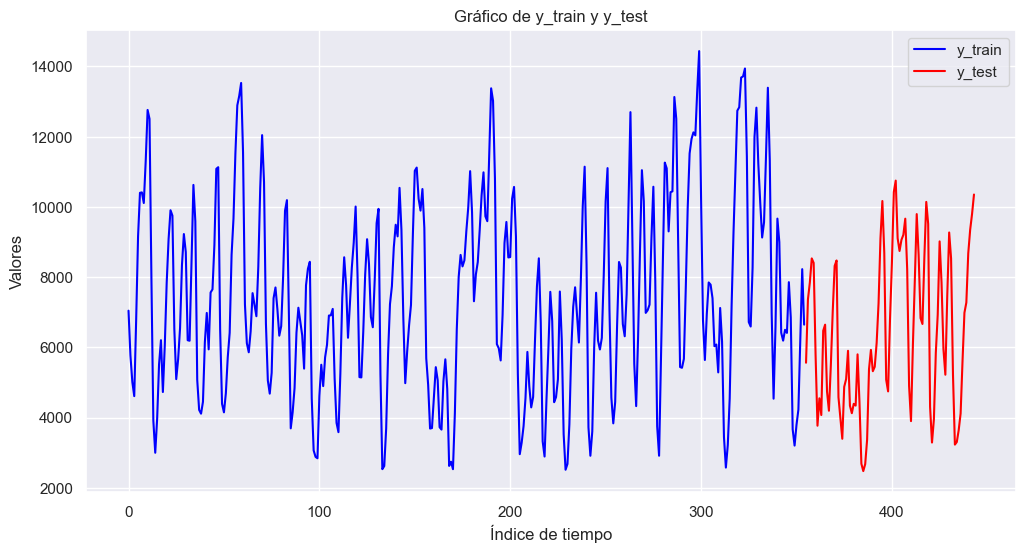

In [619]:
import matplotlib.pyplot as plt

# Crear una figura
plt.figure(figsize=(12, 6))

# Graficar y_train en azul
plt.plot(y_train, label='y_train', color='blue')

# Obtener el número de puntos en y_train
n_train = len(y_train)

# Graficar y_test en rojo a continuación de y_train
plt.plot(range(n_train, n_train + len(y_test)), y_test, label='y_test', color='red')

# Etiquetas y título
plt.xlabel('Índice de tiempo')
plt.ylabel('Valores')
plt.title('Gráfico de y_train y y_test')

# Leyenda
plt.legend()

# Rejilla
plt.grid(True)

# Mostrar el gráfico
plt.show()




## Metricas

Aqui se determinan las metricas de interes para el estudio.

* RRMSE: corresponde a "Root Relative Mean Squared Error," que es una métrica utilizada para evaluar la precisión de un modelo en términos de la diferencia entre sus predicciones y los valores reales
* MAE: Es una métrica de error que cuantifica el promedio de las magnitudes de los errores absolutos entre las predicciones y los valores reales.
* R2: Proporciona una medida de cuánta variabilidad en la variable dependiente (la variable que se está prediciendo) puede ser explicada por el modelo de regresión.
* NSE: Es una métrica que se usa para evaluar cuán bien un modelo reproduce la variabilidad de los datos en comparación con una predicción simple que sería la media de los datos observados.

In [539]:
def metricas(y_test, y_pred, modelo):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rrmse = np.sqrt(np.mean((y_test - y_pred) ** 2)) / np.mean(y_test)
    r2 = r2_score(y_test, y_pred)
    nse = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

    # Crear un diccionario con los resultados
    resultados = {
        'Modelo': modelo,
        'MAE': '{:.3f}'.format(mae),
        'RRMSE': '{:.3f}'.format(rrmse),
        'R-squared (R^2)': '{:.3f}'.format(r2),
        'NSE (Nash-Sutcliffe Efficiency)': '{:.3f}'.format(nse)
    }
    
    # Calcular la línea de regresión (línea de mejor ajuste)
    coeff = np.polyfit(y_test, y_pred, 1)
    line = np.poly1d(coeff)

    # Calcular el coeficiente de determinación (R²)
    r2 = r2_score(y_test, y_pred)

    # Graficar los puntos en azul
    plt.scatter(y_test, y_pred, c='blue', marker='o', s=10)

    # Graficar la línea de regresión en rojo
    plt.plot(y_test, line(y_test), c='red', label=f'$y = {coeff[0]:.2f}x + {coeff[1]:.2f}$\n$R^2 = {r2:.2f}$')

    # Etiquetas y título
    plt.xlabel('Valores Reales', fontsize=10)
    plt.ylabel(f'{modelo} (m3/s)', fontsize=10)
    plt.title(f'Gráfico de Valores Reales vs. Valores Predichos\nModelo: {modelo}', fontsize=12)

    # Mostrar la leyenda
    plt.legend(fontsize=10)

    # Mostrar el gráfico
    plt.show()


    # Crear un DataFrame a partir del diccionario
    df_resultados = pd.DataFrame([resultados])

    return df_resultados


columnas = ['Modelo', 'MAE', 'RRMSE', 'R-squared (R^2)', 'NSE (Nash-Sutcliffe Efficiency)']
df_resultados = pd.DataFrame(columns=columnas)

## ARIMA

In [540]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# Load dataset

# Split into train and test sets
X = serie_ARIMA['Flow'].values
train, test = X[:size], X[size:]



## Funcion ARIMA

In [541]:

def ARIMA_estimador(serie_ARIMA, orden):
    # Split into train and test sets
    predictions = []
    residuales = []
    X = serie_ARIMA['Flow'].values
    size = int(len(X) * 0.8)
    train, test = X[:size], X[size:]

    history = [x for x in train]
    
    # Walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=orden)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('Month=%s, Predicted=%f, Expected=%f' % (serie_ARIMA['Mes'].iloc[size + t], yhat, obs))

    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=orden)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        residuales.append(obs-yhat)

    fig = plt.figure(figsize=(12, 6))
    plt.plot(serie_ARIMA['Mes'].iloc[size:], test, marker='o', linestyle='', label='Actual')
    plt.plot(serie_ARIMA['Mes'].iloc[size:], predictions, color='red', label='Predicted')
    plt.xlabel('Tiempo (Mes)')
    plt.ylabel('Caudal (m3/s)')
    plt.legend()
    plt.title('River Flow Forecast')
    plt.xticks(rotation=0)
    plt.show()


    # Evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)

    # Plot forecasts against actual outcomes
    fig = plt.figure(figsize=(12, 6))
    plt.plot(serie_ARIMA['Mes'].iloc[size:], residuales, color='red', label='Residuales')
    plt.xlabel('Tiempo (Mes)')
    plt.ylabel('Caudal (m3/s)')
    plt.legend()
    plt.title('Residuales obtenidos')
    plt.xticks(rotation=0)  # Rotate x-axis labels for readability
    plt.show()
    
    
    return predictions, residuales


## Modelos lineales
Entre los modelos lineales se encuentran: autoregressive (AR), moving average (MA), and autoregressive moving average (ARMA)

### AR

In [542]:
import pmdarima as pm

model_1 = pm.auto_arima(X, start_p=1, start_q=0,
                      test='adf',
                      max_p=5, max_q=0,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7865.329, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9208.012, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7777.791, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7662.598, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=7641.101, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=7639.764, Time=0.17 sec


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=7603.639, Time=0.24 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=7601.648, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=7606.573, Time=0.08 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 0.986 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  444
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -3794.824
Date:                Sat, 07 Oct 2023   AIC                           7601.648
Time:                        05:50:21   BIC                           7626.223
Sample:                             0   HQIC                          7611.340
                                - 444                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

* Se ajusta el orden de AR.

In [543]:
orden_ar=(5, 0, 0) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  355
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -3036.744
Date:                Sat, 07 Oct 2023   AIC                           6087.488
Time:                        05:50:22   BIC                           6114.593
Sample:                             0   HQIC                          6098.271
                                - 355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7413.0301    367.764     20.157      0.000    6692.227    8133.834
ar.L1          1.4205      0.057     24.728      0.000       1.308       1.533
ar.L2         -0.8886      0.095     -9.400      0.0

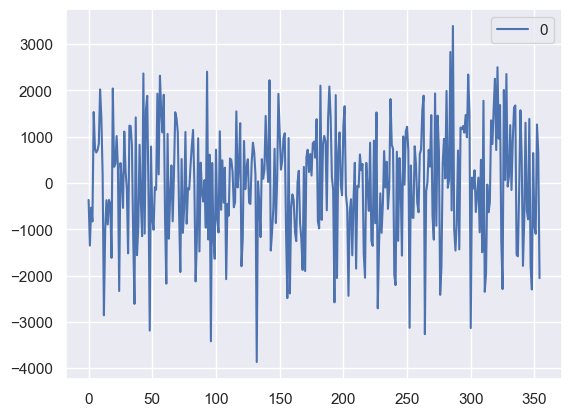

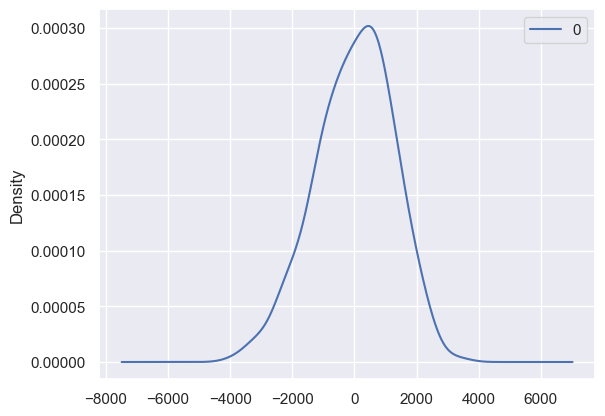

                 0
count   355.000000
mean     -5.996724
std    1254.328712
min   -3866.216294
25%    -843.690613
50%      66.530667
75%     869.953976
max    3390.829384


In [544]:
# fit model
model = ARIMA(train, order=orden_ar)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

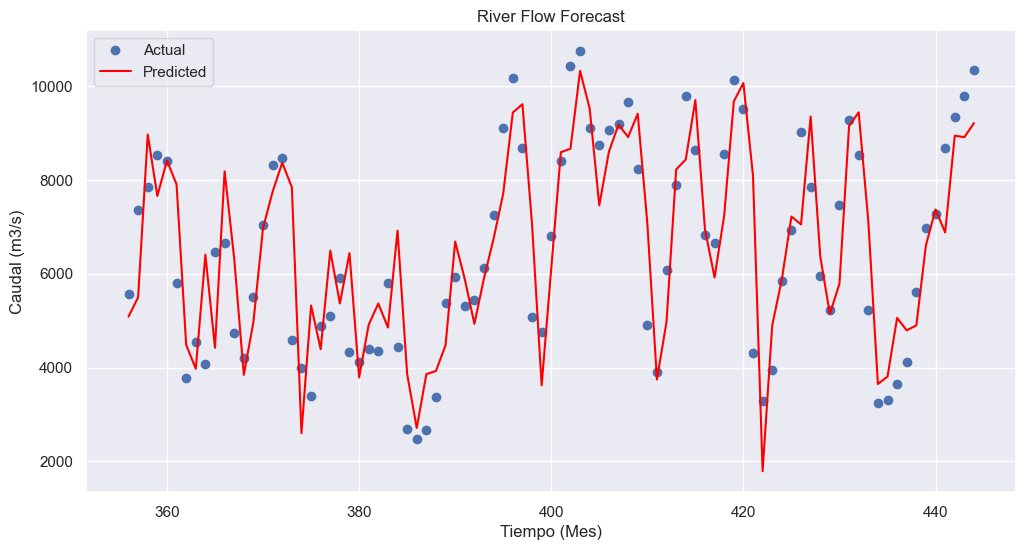

Test RMSE: 1216.840


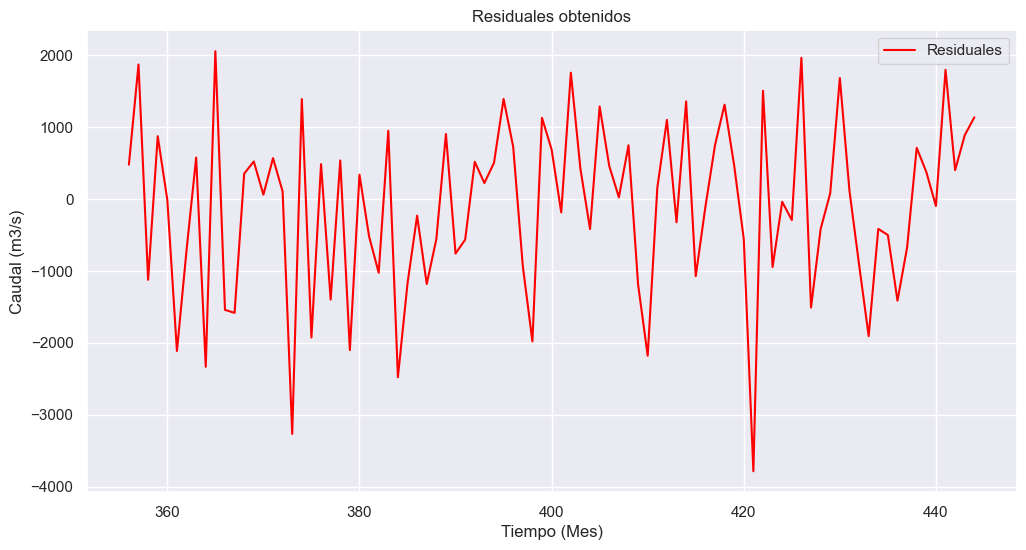

In [545]:
predictions = []
residuales = []

predictions_AR, residuales_AR = ARIMA_estimador(serie_ARIMA, orden_ar)

##### Metricas del modelo

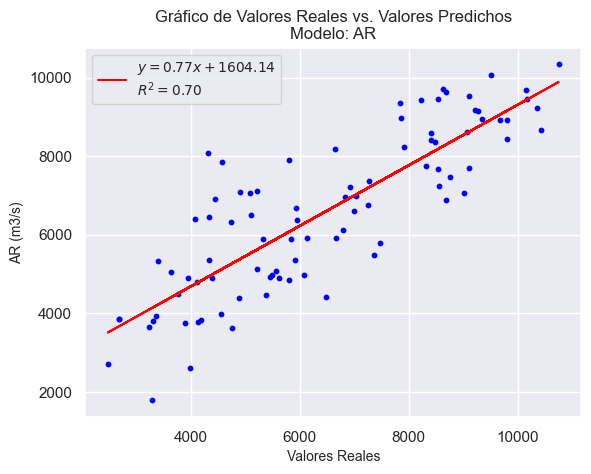

  Modelo      MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR  968.170  0.188           0.697                           0.697


In [546]:
nueva_fila = metricas(y_test, predictions_AR, 'AR')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

### ARMA

In [547]:
import pmdarima as pm

model_1 = pm.auto_arima(X, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7727.800, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9208.012, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7865.329, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7724.921, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7777.791, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7640.387, Time=0.42 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7662.598, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=7641.410, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7605.158, Time=0.70 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=7555.284, Time=0.80 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=7557.907, T

In [548]:
orden_arma=(4, 0, 5)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  355
Model:                 ARIMA(4, 0, 5)   Log Likelihood               -2995.997
Date:                Sat, 07 Oct 2023   AIC                           6013.995
Time:                        05:51:15   BIC                           6056.588
Sample:                             0   HQIC                          6030.939
                                - 355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7413.0299    348.775     21.254      0.000    6729.444    8096.616
ar.L1          0.7306      0.074      9.913      0.000       0.586       0.875
ar.L2         -0.0220      0.099     -0.222      0.8

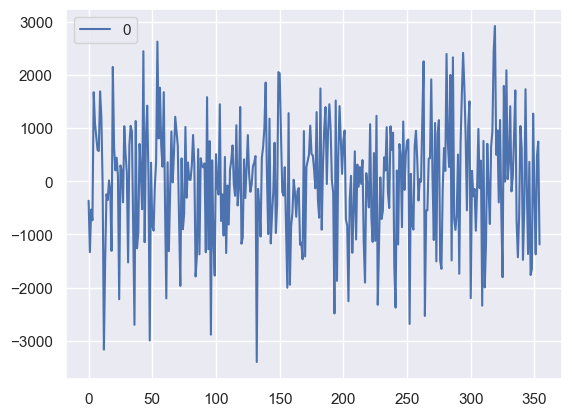

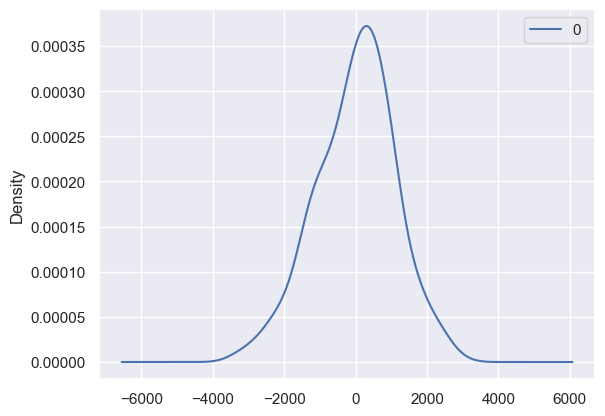

                 0
count   355.000000
mean     -4.248366
std    1115.165675
min   -3397.589457
25%    -729.395565
50%      99.649280
75%     738.218897
max    2916.631266


In [549]:
# fit model
model = ARIMA(train, order=orden_arma)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [550]:
serie_ARIMA

,Flow,Mes
0,7046.387097,1
1,5769.344828,2
2,5016.483871,3
3,4613.266667,4
4,6783.838710,5
...,...,...
439,7277.535484,440
440,8679.066667,441
441,9349.567742,442
442,9804.350000,443


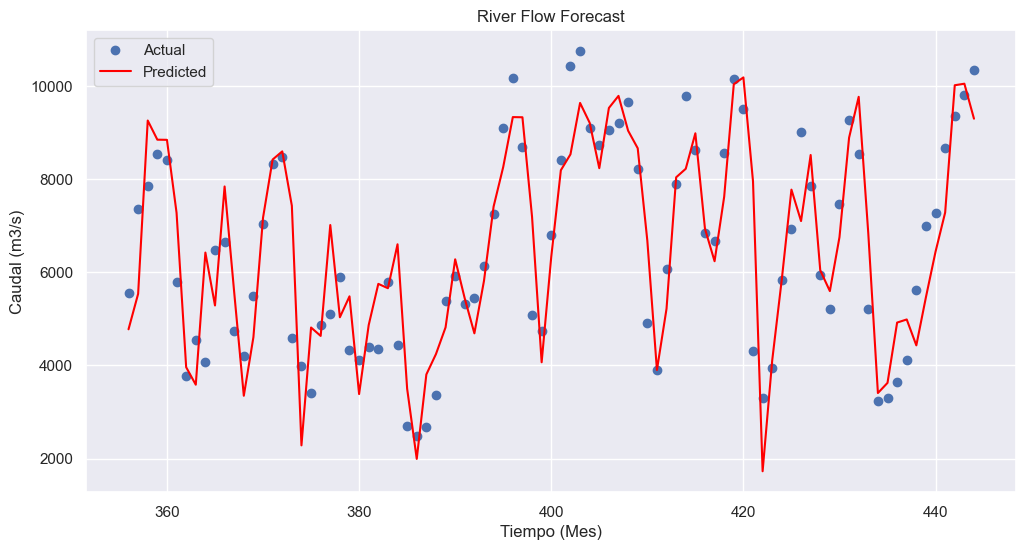

Test RMSE: 1099.972


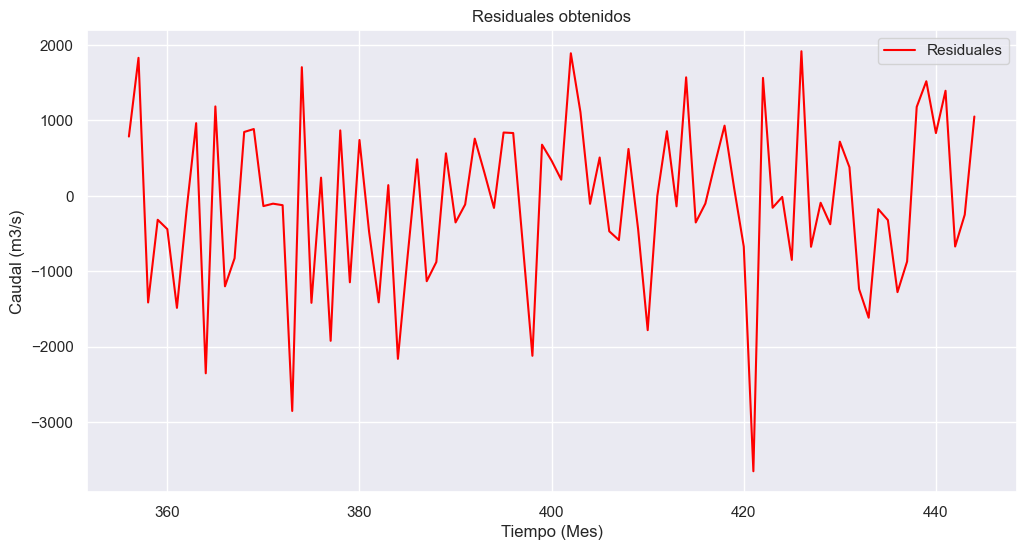

In [551]:
predictions_ARMA, residuales_ARMA = ARIMA_estimador(serie_ARIMA, orden_arma)

##### Metricas del modelo

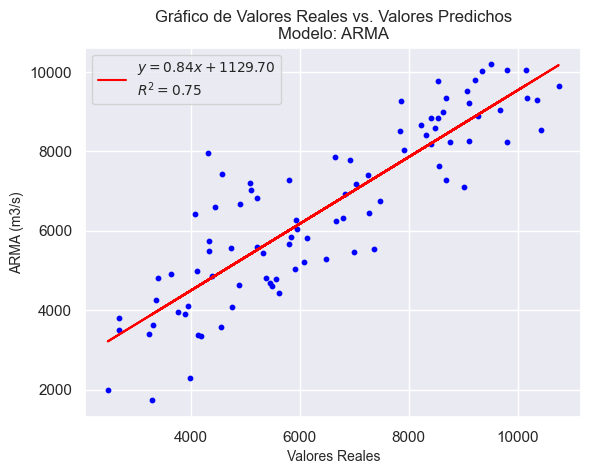

  Modelo      MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR  968.170  0.188           0.697                           0.697
1   ARMA  864.345  0.170           0.753                           0.753


In [552]:
nueva_fila = metricas(y_test, predictions_ARMA, 'ARMA')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

## Ridge

In [553]:
from sklearn.linear_model import Ridge

alpha_values = np.logspace(-1, 1, 100)  # Generates values from 1e-6 to 1e6 with 13 points

# Definir el conjunto de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'ridge__alpha': alpha_values,
}

# Crear el pipeline con MinMaxScaler y Ridge
pipe = make_pipeline(MinMaxScaler(), Ridge())

# Realizar la búsqueda en cuadrícula
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])},
             scoring='r2')

In [554]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridge', Ridge(alpha=0.30538555088334157))])


In [555]:
y_pred = grid.predict(X_test)
print("Training-set score: {:.2f}".format(grid.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))


Training-set score: 0.64
Test-set score: 0.59


##### Metricas del modelo

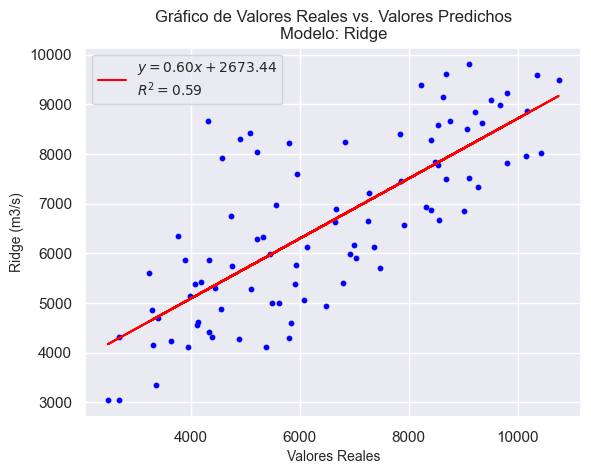

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   864.345  0.170           0.753                           0.753
2  Ridge  1131.050  0.220           0.587                           0.587


In [556]:
nueva_fila = metricas(y_test, y_pred, 'Ridge')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

## Lasso

In [557]:
from sklearn.linear_model import Lasso

alpha_values = np.logspace(-1, 1, 100)  # Generates values from 1e-6 to 1e6 with 13 points

# Definir el conjunto de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'lasso__alpha': alpha_values,
}

# Crear el pipeline con MinMaxScaler y Lasso
pipe = make_pipeline(MinMaxScaler(), Lasso())

# Realizar la búsqueda en cuadrícula
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])},
             scoring='r2')

In [558]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=0.11497569953977356))])


In [559]:
y_pred = grid.predict(X_test)
print("Training-set score: {:.2f}".format(grid.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Training-set score: 0.64
Test-set score: 0.59


##### Metricas del modelo

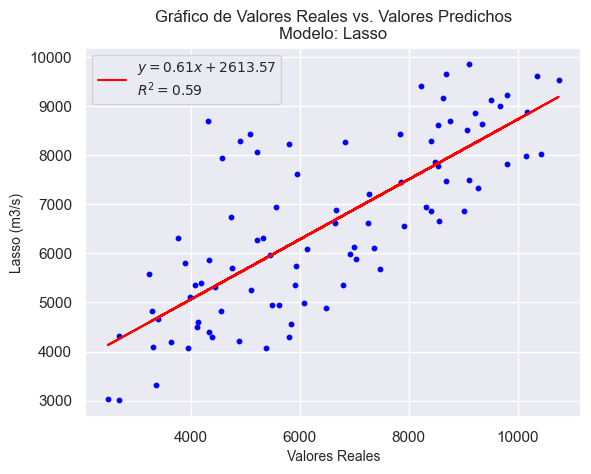

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   864.345  0.170           0.753                           0.753
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586


In [560]:
nueva_fila = metricas(y_test, y_pred, 'Lasso')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

## Random Forest

In [561]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [562]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
param_grid = {'randomforestregressor__max_depth': [2,3,4],
              'randomforestregressor__n_estimators': [400],
              'randomforestregressor__max_leaf_nodes': [2,4,6,8],
              'randomforestregressor__min_samples_split': [2,5,10,15]}

RF = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
RF.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [2, 3, 4],
                         'randomforestregressor__max_leaf_nodes': [2, 4, 6, 8],
                         'randomforestregressor__min_samples_split': [2, 5, 10,
                                                                      15],
                         'randomforestregressor__n_estimators': [400]},
             scoring='r2')

In [563]:
print("Best estimator:\n{}".format(RF.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=3, max_leaf_nodes=8,
                                       min_samples_split=15,
                                       n_estimators=400))])


In [564]:
print("Training-set score: {:.2f}".format(RF.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(RF.score(X_test, y_test)))


Training-set score: 0.68
Test-set score: 0.54


In [565]:
y_pred = RF.predict(X_test)

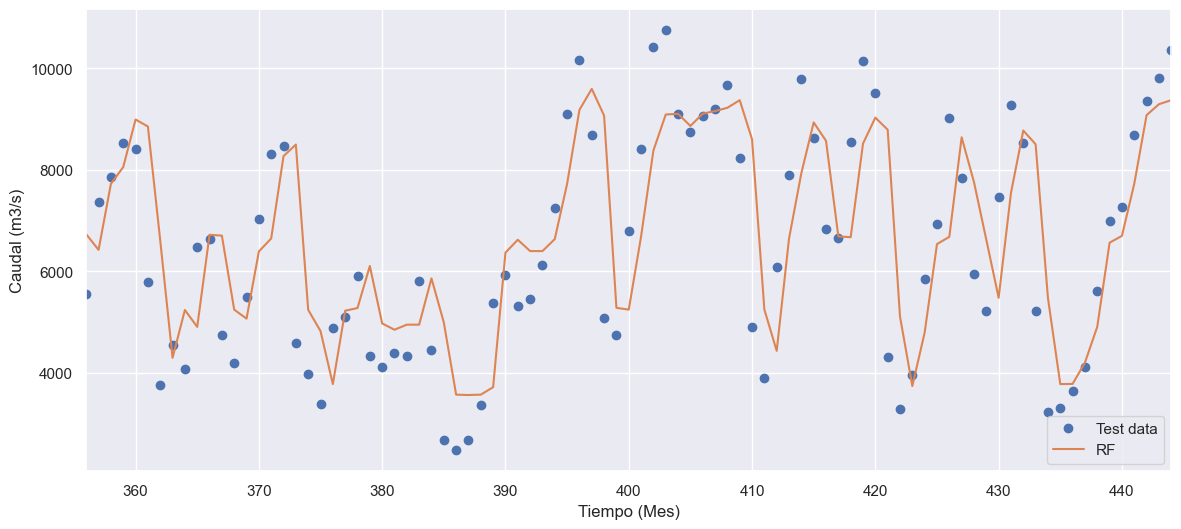

In [566]:
fig = plt.figure(figsize=(14, 6))
plt.plot(data_test.Mes, y_test, marker='o', linestyle='', label="Test data")
plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y

plt.xlim(data_test.Mes.min(), data_test.Mes.max())

plt.show()

##### Metricas del modelo

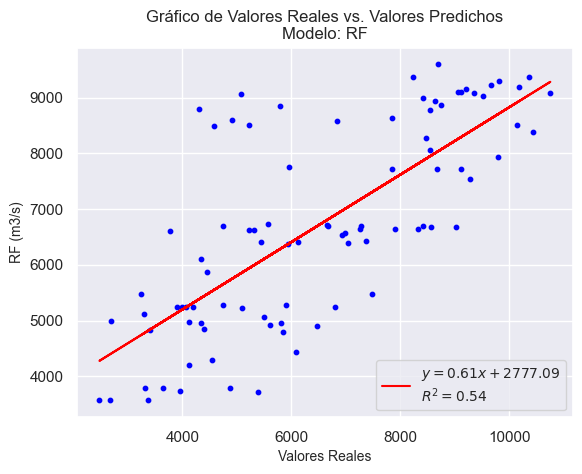

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   864.345  0.170           0.753                           0.753
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1164.948  0.233           0.535                           0.535


In [567]:
nueva_fila = metricas(y_test, y_pred, 'RF')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

## k-NN regresor

In [568]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

In [569]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

In [570]:
param_grid = {'kneighborsregressor__n_neighbors': [1,2,4,6,8,10,15,20,30,40]}

In [571]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [1, 2, 4, 6, 8, 10,
                                                              15, 20, 30, 40]},
             scoring='r2')

In [572]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=15))])


In [573]:
y_pred = grid.predict(X_test)

In [574]:
print("Training-set score: {:.2f}".format(grid.score(X_train, y_train)))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Training-set score: 0.66
Test-set score: 0.53


##### Metricas del modelo

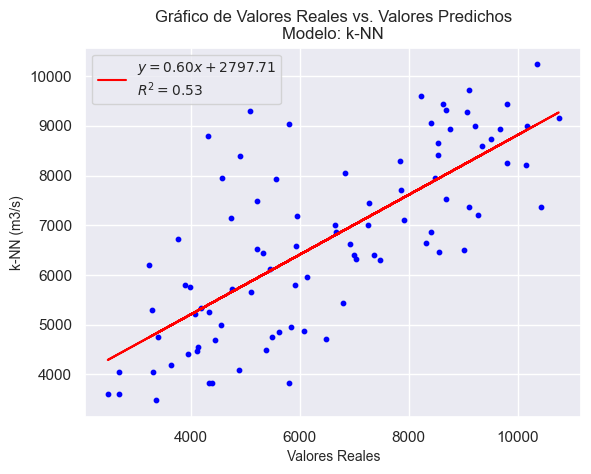

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   864.345  0.170           0.753                           0.753
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1164.948  0.233           0.535                           0.535
5   k-NN  1174.654  0.234           0.531                           0.531


In [575]:
nueva_fila = metricas(y_test, y_pred, 'k-NN')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

## SVR

In [576]:
from sklearn.svm import SVR

In [577]:
param_grid = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'svr__epsilon': [0.00001, 0.0001, 0.001, 0.01,0.1, 0.2, 0.5, 1]
}

In [578]:
pipe = make_pipeline(MinMaxScaler(), SVR())

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svr__epsilon': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.2,
                                          0.5, 1],
                         'svr__kernel': ['linear', 'rbf']},
             scoring='r2')

In [579]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svr', SVR(C=1000, epsilon=1e-05, kernel='linear'))])


In [580]:
y_pred = grid.predict(X_test)

##### Metricas del modelo

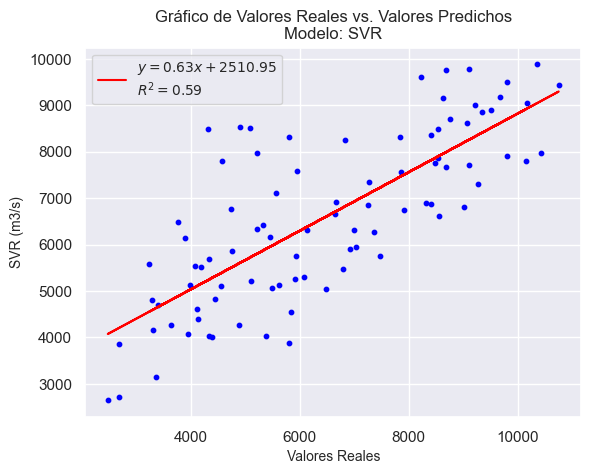

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   864.345  0.170           0.753                           0.753
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1164.948  0.233           0.535                           0.535
5   k-NN  1174.654  0.234           0.531                           0.531
6    SVR  1113.386  0.220           0.586                           0.586


In [581]:
nueva_fila = metricas(y_test, y_pred, 'SVR')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

## Redes Neuronales

In [582]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

In [583]:
# Define el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Epoch 1/200


3/3 [==============================] - 1s 89ms/step - loss: 42791604.0000 - val_loss: 46834724.0000
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 30364918.0000 - val_loss: 30404640.0000
Epoch 3/200
3/3 [==============================] - 0s 24ms/step - loss: 19508344.0000 - val_loss: 17307824.0000
Epoch 4/200
3/3 [==============================] - 0s 27ms/step - loss: 10814954.0000 - val_loss: 8145768.5000
Epoch 5/200
3/3 [==============================] - 0s 28ms/step - loss: 5145690.5000 - val_loss: 3836257.7500
Epoch 6/200
3/3 [==============================] - 0s 22ms/step - loss: 3032644.5000 - val_loss: 4018757.5000
Epoch 7/200
3/3 [==============================] - 0s 21ms/step - loss: 3450322.0000 - val_loss: 5878961.5000
Epoch 8/200
3/3 [==============================] - 0s 29ms/step - loss: 4653126.0000 - val_loss: 6429401.0000
Epoch 9/200
3/3 [==============================] - 0s 27ms/step - loss: 4745808.5000 - val_loss: 5355186.0000
Epoch 10/200
3/

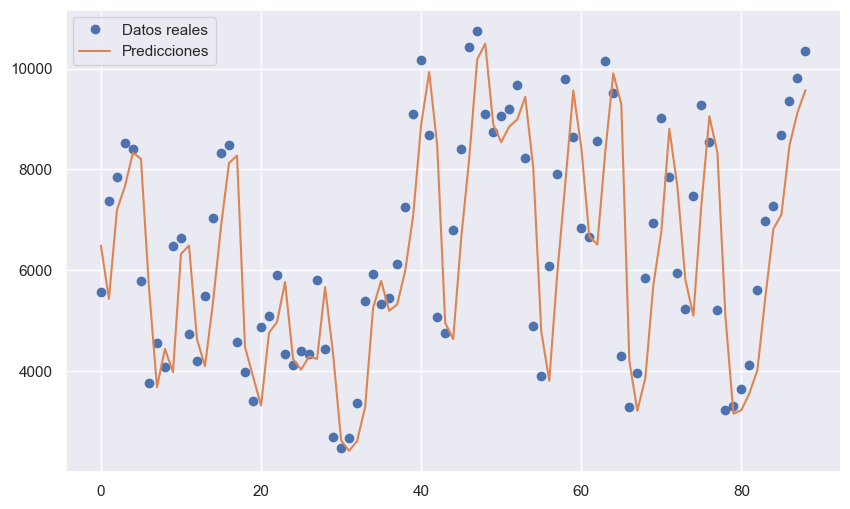

In [584]:
# Define el modelo de red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1])),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

# Compila el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

indice = int(0.8 * len(X_train))

X_trainval = X_train[:indice]
y_trainval = y_train[:indice]
X_val = X_train[indice:]
y_val = y_train[indice:]

scaler = MinMaxScaler()


model.fit(X_trainval, y_trainval, epochs=200,
                        batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evalúa el modelo en datos de prueba
y_pred = model.predict(X_test)
y_pred = y_pred.flatten().tolist()



# Grafica los resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Datos reales', marker='o', linestyle='' )
plt.plot(y_pred, label='Predicciones')
plt.legend()
plt.show()


##### Metricas del modelo

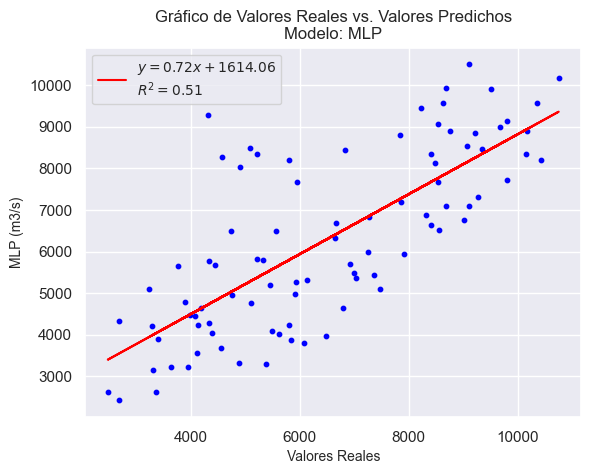

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   864.345  0.170           0.753                           0.753
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1164.948  0.233           0.535                           0.535
5   k-NN  1174.654  0.234           0.531                           0.531
6    SVR  1113.386  0.220           0.586                           0.586
7    MLP  1241.818  0.239           0.514                           0.514


In [585]:
nueva_fila = metricas(y_test, y_pred, 'MLP')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

## Modelo Hibrido


### Random Forest con modelos lineales 
Entre los modelos lineales se encuentran: autoregressive (AR), moving average (MA), and autoregressive moving average (ARMA)

Para medir el rendimiento de todos los modelos desarrollados de manera cualitativa, los valores de RRMSE (Error Cuadrático Medio Raíz Relativo) se categorizaron de la siguiente manera:
* Excelente: 0% < RRMSE < 10%
* Bueno: 10% < RRMSE < 20%
* Regular: 20% < RRMSE < 30%
* Malo: RRMSE > 30%


### AR-RF

In [586]:
best_order = orden_ar
history = [x for x in train]
model = ARIMA(history, order=best_order)
model_fit = model.fit()

residuals_train = model_fit.resid

residuales_train_lag = np.roll(residuals_train, shift=1)
#residuales_train_extra = residuales_train_lag
residuales_train_extra = np.column_stack((residuales_train_lag, X_train[:, 1]))
residuales_train_extra = residuales_train_extra[1:]

residuals_train = residuals_train[1:]


In [587]:
len(residuales_train_extra)

354

In [588]:
residuales_test_lag = np.roll(residuales_AR, shift=1)
residuales_test_extra = np.column_stack((residuales_test_lag, X_test[:, 1]))
residuales_test_extra[0] = residuales_train_extra[-1]

Text(0, 0.5, 'Caudal (m3/s)')

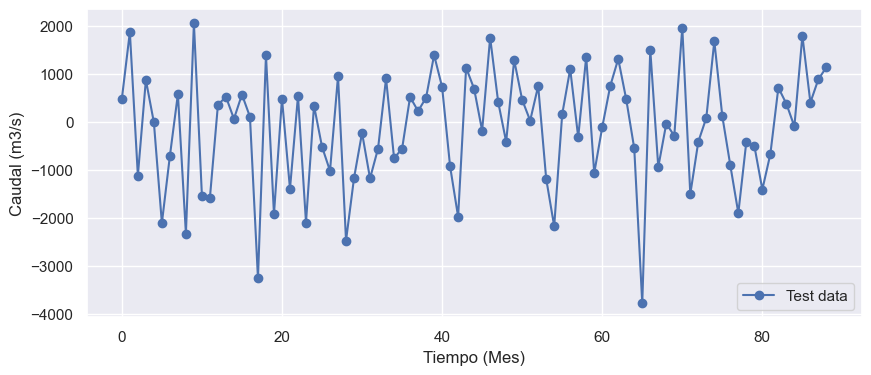

In [589]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuales_AR, marker='o', label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y


Text(0, 0.5, 'Caudal (m3/s)')

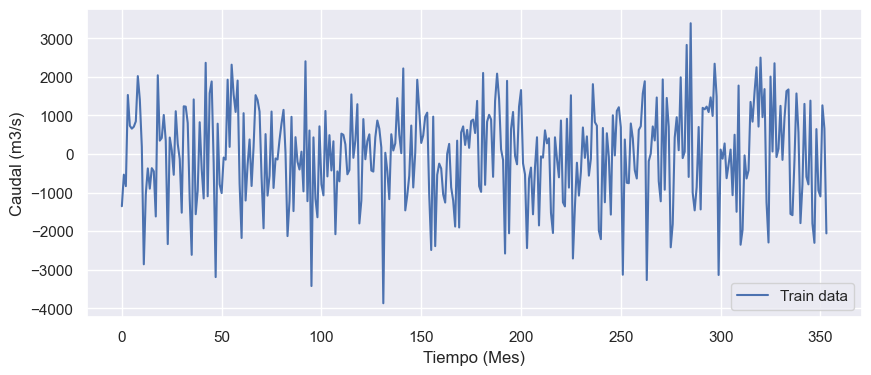

In [590]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuals_train, label="Train data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y



In [591]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
param_grid = {'randomforestregressor__max_depth': [2,3,4],
              'randomforestregressor__n_estimators': [400],
              'randomforestregressor__max_leaf_nodes': [2,4,6,8],
              'randomforestregressor__min_samples_split': [2,5,10,15]}

RF_e = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
RF_e.fit(residuales_train_extra, residuals_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [2, 3, 4],
                         'randomforestregressor__max_leaf_nodes': [2, 4, 6, 8],
                         'randomforestregressor__min_samples_split': [2, 5, 10,
                                                                      15],
                         'randomforestregressor__n_estimators': [400]},
             scoring='r2')

In [592]:
print("Best estimator:\n{}".format(RF_e.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=2, max_leaf_nodes=6,
                                       min_samples_split=15,
                                       n_estimators=400))])


In [593]:
y_pred = RF_e.predict(residuales_test_extra)

In [594]:
"""plt.figure(figsize=(14,6))
plt.plot(residuals_train, label="Training data")
#plt.plot(residuales_AR, label="Test data")
plt.plot(y_tree, label="Tree prediction")
plt.legend();

"""

'plt.figure(figsize=(14,6))\nplt.plot(residuals_train, label="Training data")\n#plt.plot(residuales_AR, label="Test data")\nplt.plot(y_tree, label="Tree prediction")\nplt.legend();\n\n'

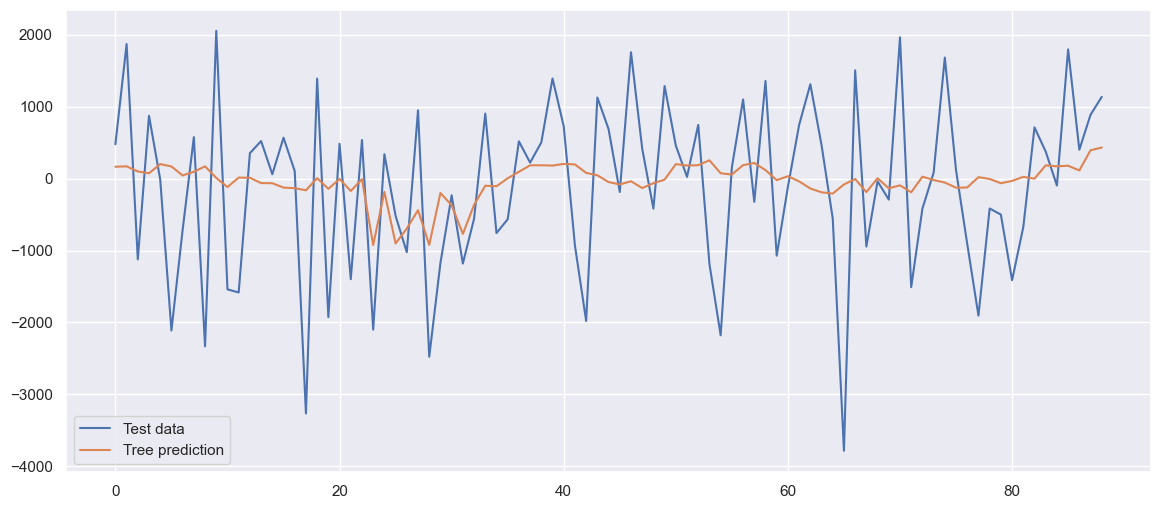

In [595]:
plt.figure(figsize=(14,6))
plt.plot(residuales_AR, label="Test data")
plt.plot(y_pred, label="Tree prediction")
plt.legend();


In [596]:
print("Training-set score: {:.2f}".format(RF_e.score(residuales_train_extra, residuals_train)))
print("Test-set score: {:.2f}".format(RF_e.score(residuales_test_extra, residuales_AR)))


Training-set score: 0.11
Test-set score: 0.09


In [597]:
y_residual = RF_e.predict(residuales_test_extra)

y_AR_RF = predictions_AR + y_residual


##### Metricas del modelo

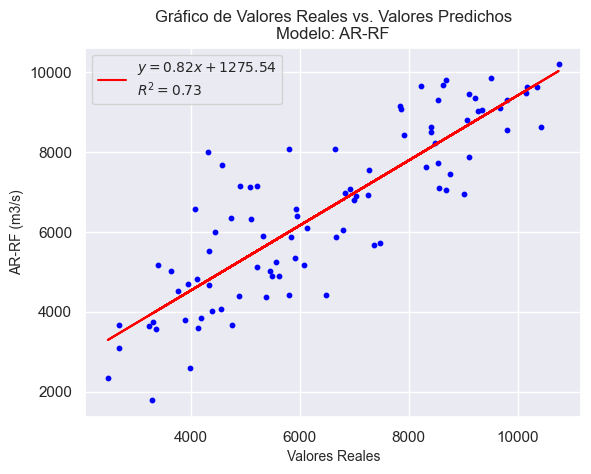

  Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0     AR   968.170  0.188           0.697                           0.697
1   ARMA   864.345  0.170           0.753                           0.753
2  Ridge  1131.050  0.220           0.587                           0.587
3  Lasso  1130.720  0.220           0.586                           0.586
4     RF  1164.948  0.233           0.535                           0.535
5   k-NN  1174.654  0.234           0.531                           0.531
6    SVR  1113.386  0.220           0.586                           0.586
7    MLP  1241.818  0.239           0.514                           0.514
8  AR-RF   906.107  0.179           0.726                           0.726


In [598]:
nueva_fila = metricas(test, y_AR_RF, 'AR-RF')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

### AR-MODEL

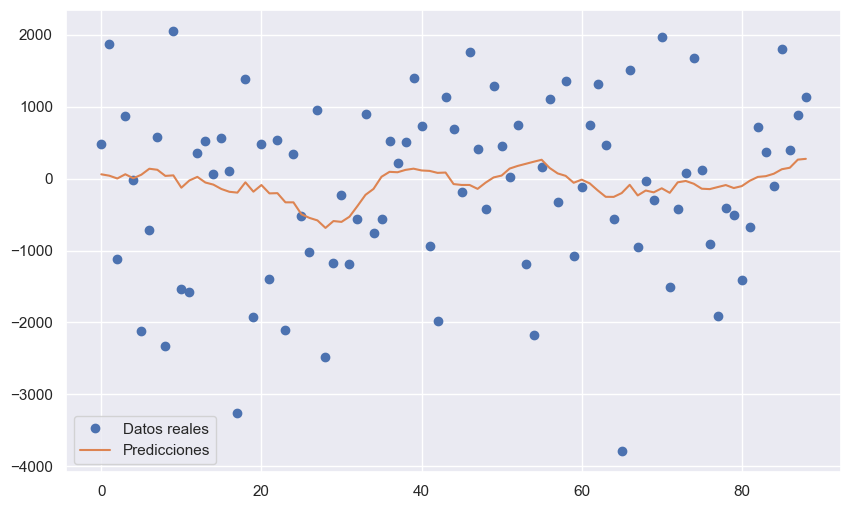

In [599]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define a range of alpha values you want to test
alpha_values = np.logspace(-6, 6, 1000)  # Adjust as needed

# Create a pipeline with StandardScaler and Ridge regression
pipe = make_pipeline(StandardScaler(), Ridge())

# Define the parameter grid for the Ridge regression
param_grid = {'ridge__alpha': alpha_values}

# Create the GridSearchCV object
ridge_grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)

# Fit the model to your training data
ridge_grid.fit(residuales_train_extra, residuals_train)


# Evalúa el modelo en datos de prueba escalados
y_pred_ridge = ridge_grid.predict(residuales_test_extra)

# Grafica los resultados
plt.figure(figsize=(10, 6))
plt.plot(residuales_AR, label='Datos reales', marker='o', linestyle='' )
plt.plot(y_pred_ridge, label='Predicciones')
plt.legend()
plt.show()



In [600]:
#metricas(residuales_AR, y_pred_ridge)

In [601]:

y_AR_Ridge = predictions_AR + y_pred_ridge

##### Metricas del modelo

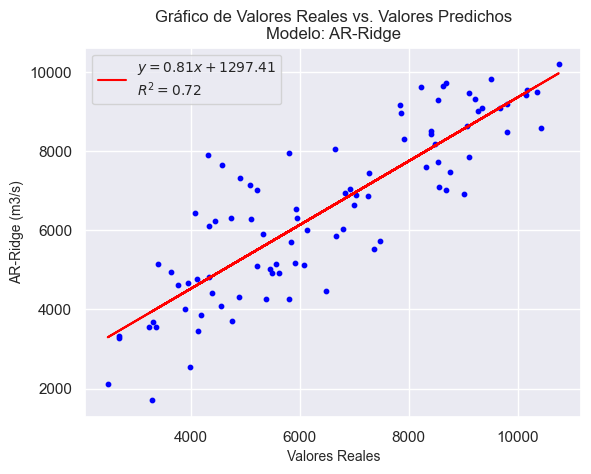

     Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0        AR   968.170  0.188           0.697                           0.697
1      ARMA   864.345  0.170           0.753                           0.753
2     Ridge  1131.050  0.220           0.587                           0.587
3     Lasso  1130.720  0.220           0.586                           0.586
4        RF  1164.948  0.233           0.535                           0.535
5      k-NN  1174.654  0.234           0.531                           0.531
6       SVR  1113.386  0.220           0.586                           0.586
7       MLP  1241.818  0.239           0.514                           0.514
8     AR-RF   906.107  0.179           0.726                           0.726
9  AR-Ridge   921.063  0.181           0.721                           0.721


In [602]:
nueva_fila = metricas(test, y_AR_Ridge, 'AR-Ridge')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

### ARMA-RF

In [603]:
best_order = orden_arma
history = [x for x in train]
model = ARIMA(history, order=best_order)
model_fit = model.fit()

residuals_train = model_fit.resid

residuales_train_lag = np.roll(residuals_train, shift=1)
#residuales_train_extra = residuales_train_lag
residuales_train_extra = np.column_stack((residuales_train_lag, X_train[:, 1]))
residuales_train_extra = residuales_train_extra[1:]
residuals_train = residuals_train[1:]


In [604]:
residuales_test_lag = np.roll(residuales_ARMA, shift=1)
residuales_test_extra = np.column_stack((residuales_test_lag, X_test[:, 1]))
residuales_test_extra[0] = residuales_train_extra[-1]

Text(0, 0.5, 'Caudal (m3/s)')

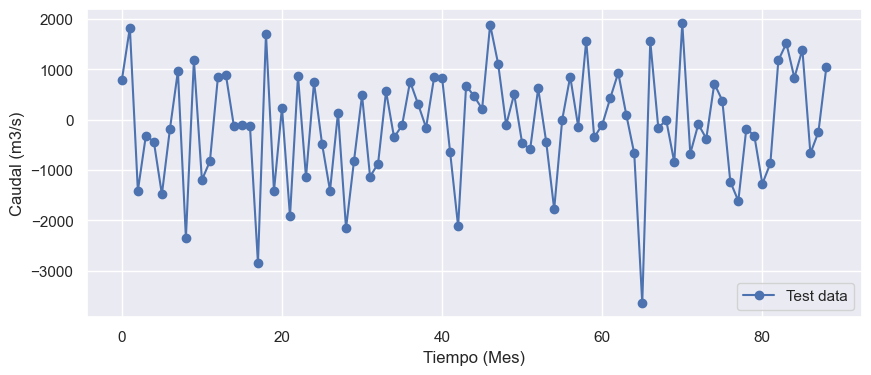

In [605]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuales_ARMA, marker='o', label="Test data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y


Text(0, 0.5, 'Caudal (m3/s)')

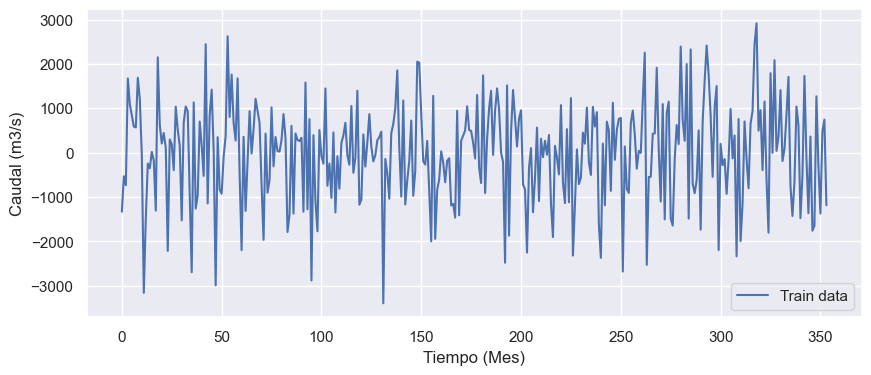

In [606]:
fig = plt.figure(figsize=(10, 4))
plt.plot(residuals_train, label="Train data")
#plt.plot(data_test.Mes, y_pred, label="RF")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Agregamos nombres a los ejes
plt.xlabel("Tiempo (Mes)")  # Nombre del eje x
plt.ylabel("Caudal (m3/s)")  # Nombre del eje y



In [607]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
param_grid = {'randomforestregressor__max_depth': [2,3,4],
              'randomforestregressor__n_estimators': [400],
              'randomforestregressor__max_leaf_nodes': [2,4,6,8],
              'randomforestregressor__min_samples_split': [2,5,10,15]}

RF_e = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
RF_e.fit(residuales_train_extra, residuals_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [2, 3, 4],
                         'randomforestregressor__max_leaf_nodes': [2, 4, 6, 8],
                         'randomforestregressor__min_samples_split': [2, 5, 10,
                                                                      15],
                         'randomforestregressor__n_estimators': [400]},
             scoring='r2')

In [608]:
print("Best estimator:\n{}".format(RF_e.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=2, max_leaf_nodes=8,
                                       n_estimators=400))])


In [609]:
y_pred = RF_e.predict(residuales_test_extra)

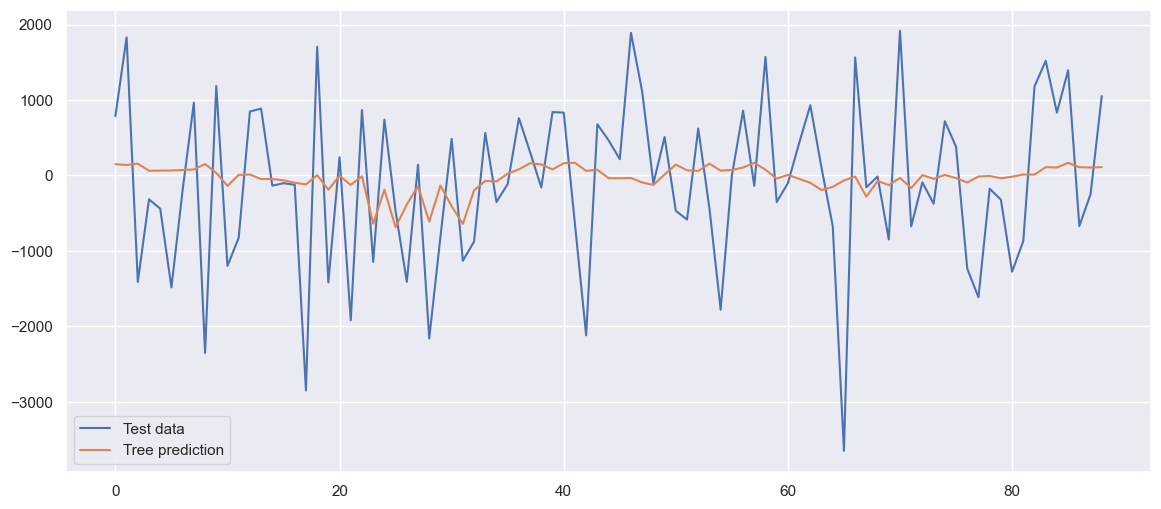

In [610]:
plt.figure(figsize=(14,6))
plt.plot(residuales_ARMA, label="Test data")
plt.plot(y_pred, label="Tree prediction")
plt.legend();


In [611]:
print("Training-set score: {:.2f}".format(RF_e.score(residuales_train_extra, residuals_train)))
print("Test-set score: {:.2f}".format(RF_e.score(residuales_test_extra, residuales_AR)))


Training-set score: 0.10
Test-set score: 0.07


In [612]:
y_ARMA_RF = predictions_ARMA + y_pred

##### Metricas del modelo

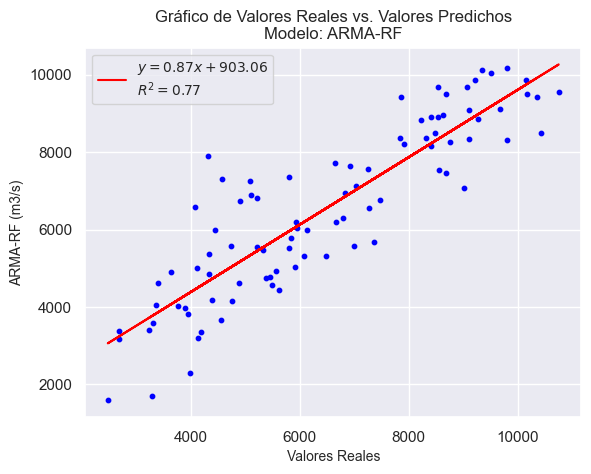

      Modelo       MAE  RRMSE R-squared (R^2) NSE (Nash-Sutcliffe Efficiency)
0         AR   968.170  0.188           0.697                           0.697
1       ARMA   864.345  0.170           0.753                           0.753
2      Ridge  1131.050  0.220           0.587                           0.587
3      Lasso  1130.720  0.220           0.586                           0.586
4         RF  1164.948  0.233           0.535                           0.535
5       k-NN  1174.654  0.234           0.531                           0.531
6        SVR  1113.386  0.220           0.586                           0.586
7        MLP  1241.818  0.239           0.514                           0.514
8      AR-RF   906.107  0.179           0.726                           0.726
9   AR-Ridge   921.063  0.181           0.721                           0.721
10   ARMA-RF   831.521  0.164           0.770                           0.770


In [613]:
nueva_fila = metricas(test, y_ARMA_RF, 'ARMA-RF')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

### ARMA-MODEL

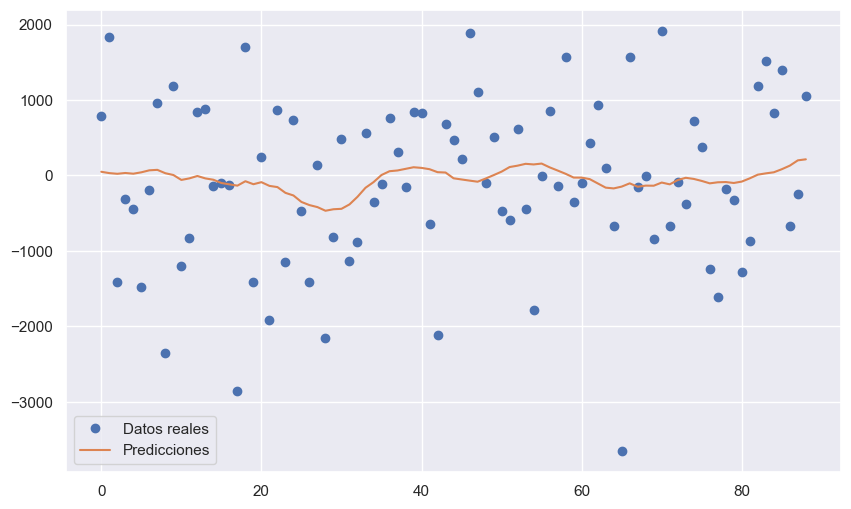

In [614]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define a range of alpha values you want to test
alpha_values = np.logspace(-6, 6, 1000)  # Adjust as needed

# Create a pipeline with StandardScaler and Ridge regression
pipe = make_pipeline(MinMaxScaler(), Ridge())

# Define the parameter grid for the Ridge regression
param_grid = {'ridge__alpha': alpha_values}

# Create the GridSearchCV object
ridge_grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)

# Fit the model to your training data
ridge_grid.fit(residuales_train_extra, residuals_train)


# Evalúa el modelo en datos de prueba escalados
y_pred_ridge = ridge_grid.predict(residuales_test_extra)

# Grafica los resultados
plt.figure(figsize=(10, 6))
plt.plot(residuales_ARMA, label='Datos reales', marker='o', linestyle='' )
plt.plot(y_pred_ridge, label='Predicciones')
plt.legend()
plt.show()



In [615]:
#metricas(residuales_ARMA, y_pred_ridge)


In [616]:

y_ARMA_Ridge = predictions_ARMA + y_pred_ridge


##### Metricas del modelo

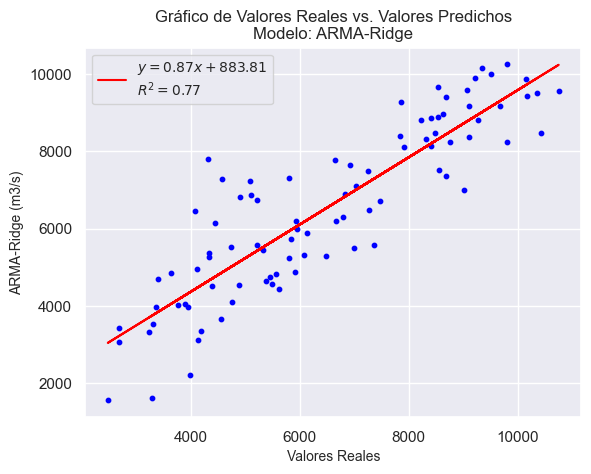

        Modelo       MAE  RRMSE R-squared (R^2)  \
0           AR   968.170  0.188           0.697   
1         ARMA   864.345  0.170           0.753   
2        Ridge  1131.050  0.220           0.587   
3        Lasso  1130.720  0.220           0.586   
4           RF  1164.948  0.233           0.535   
5         k-NN  1174.654  0.234           0.531   
6          SVR  1113.386  0.220           0.586   
7          MLP  1241.818  0.239           0.514   
8        AR-RF   906.107  0.179           0.726   
9     AR-Ridge   921.063  0.181           0.721   
10     ARMA-RF   831.521  0.164           0.770   
11  ARMA-Ridge   843.062  0.166           0.766   

   NSE (Nash-Sutcliffe Efficiency)  
0                            0.697  
1                            0.753  
2                            0.587  
3                            0.586  
4                            0.535  
5                            0.531  
6                            0.586  
7                            0.514  
8  

In [617]:
nueva_fila = metricas(test, y_ARMA_Ridge, 'ARMA-Ridge')
df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)
print(df_resultados)

# Resultados

A continuación se muestra la tabla resumen de todos los modelos implementados y las metricas calculadas.

In [618]:
df_resultados

,Modelo,MAE,RRMSE,R-squared (R^2),NSE (Nash-Sutcliffe Efficiency)
0,AR,968.170,0.188,0.697,0.697
1,ARMA,864.345,0.170,0.753,0.753
2,Ridge,1131.050,0.220,0.587,0.587
3,Lasso,1130.720,0.220,0.586,0.586
4,RF,1164.948,0.233,0.535,0.535
5,k-NN,1174.654,0.234,0.531,0.531
6,SVR,1113.386,0.220,0.586,0.586
7,MLP,1241.818,0.239,0.514,0.514
8,AR-RF,906.107,0.179,0.726,0.726
9,AR-Ridge,921.063,0.181,0.721,0.721
